# How to download flights csv file from transtats website

**In this notebook, we did**
1. Downloaded a csv file for each of our chosen year(s) and month(s)
2. Prepared the data for further processing
3. Pushed the prepared data to a table in the database




In [9]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import psycopg2 # needed to get database exception errors when uploading dataframe
import requests # package for getting data from the web
from zipfile import * # package for unzipping zip files

In [10]:
# Import the get_engine function from our sql_functions.
from sql_functions import get_engine #adjust this as necessary to match your sql_functions.py connection methods

# 1. Download csv file with flight data for your specific year/month

In the following, you are going to download a csv file containing flight data from [this website](https://transtats.bts.gov).    
You can specify, which data you want to download. 

Choose a month/year that you want to explore further.
With the following functions, you will download a csv file on public flight data from [this website](https://transtats.bts.gov) containing data of your chosen month/year.    
The file will be stored in a data folder.
Check out the url from which we download the data(https://transtats.bts.gov/PREZIP). Can we download data in this way from every source? What do you think?

In [11]:
# Specifies path for saving file
path ='data/' 
# Create the data folder
!mkdir {path}

mkdir: data/: File exists


In [12]:
# function to get specified csv file from the website https://transtats.bts.gov

def download_data(year, month):
    # Get the file from the website https://transtats.bts.gov
    zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
    # Download the database
    r = requests.get(f'{url}', verify=False)
    # Save database to local file storage
    with open(path+zip_file, 'wb') as f:
        f.write(r.content)
        print(f'--> zip_file with name: {zip_file} downloaded succesfully.' )
    

In [13]:
# function to extract the csv files inside the zip files

def extract_zip(year, month):
    # Get the file from the website https://transtats.bts.gov
    zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    with ZipFile(path+zip_file, 'r') as zip_ref:
        zip_ref.extractall(path)
        csv_file =  zip_ref.namelist()[0]
        print(f'--> zip_file was succesfully extracted to: {csv_file}.' )

Don't worry - the following download of the data you chose may take some time ...

In [14]:
years_list = [2014] # list of years you want to look at (can of course also be a single year)
months_list = [1] # list of months you want to look at (can of course also be a single month)

# download flights data as zipfile(s)
# we use a nested loop to specify the years and months to define the range of the data we would like to have 
for year in years_list:
    for month in months_list:
        download_data(year, month)
        extract_zip(year, month)

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


--> zip_file with name: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip downloaded succesfully.
--> zip_file was succesfully extracted to: On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_1.csv.


Now it is time to load the csv files into dataframes. You can create your own function equivalent to the functions above. But you need to decide whether...

- Do you need one dataframe for every month?
- Would you like to proceed with only one dataframe containing all the data you downloaded?
- One dataframe for every year?

There are certain things to consider before.
- changing column names
- dealing with missing data
- changing datatypes

In [15]:
# define the name of the csv file you want to read in
csv_file = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_1.csv'

# Read in your data
df = pd.read_csv(path+csv_file, low_memory = False)
display(df.shape)


(471949, 110)

In [16]:
display(df.head())

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2014,1,1,30,4,2014-01-30,AA,19805,AA,N006AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,1,1,31,5,2014-01-31,AA,19805,AA,N003AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,1,1,1,3,2014-01-01,AA,19805,AA,N002AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,1,1,2,4,2014-01-02,AA,19805,AA,N002AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,1,1,3,5,2014-01-03,AA,19805,AA,N014AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Prepare the csv file for further processing

In the next step, we clean and prepare our dataset.

a) Since the dataset consists of a lot of columns, we we define which ones to keep.  
(Same as known from our SQL exercises on flights data.)

In [17]:
# Columns from downloaded file that are to be kept

columns_to_keep = [
                'FlightDate',
                'DepTime',
                'CRSDepTime',
                'DepDelay',
                'ArrTime',
                'CRSArrTime',
                'ArrDelay',
                'Reporting_Airline',
                'Tail_Number',
                'Flight_Number_Reporting_Airline',
                'Origin',
                'Dest',
                'AirTime',
                'ActualElapsedTime',
                'Distance',
                'Cancelled',
                'Diverted'
]

In [30]:
# The columns in the database have different naming as in the source csv files. Lets get the names from the database

schema = 'cgn_analytics_22_3' # UPDATE 'TABLE_SCHEMA' based on schema used in class 
engine = get_engine() # assign engine to be able to query against the database

table_name_sql = f'''SELECT COLUMN_NAME 
                    FROM INFORMATION_SCHEMA.COLUMNS 
                    WHERE TABLE_NAME = 'flights'
                    AND TABLE_SCHEMA ='{schema}'
                    ORDER BY ordinal_position'''
c_names = engine.execute(table_name_sql).fetchall()
c_names

[('flight_date',),
 ('dep_time',),
 ('sched_dep_time',),
 ('dep_delay',),
 ('arr_time',),
 ('sched_arr_time',),
 ('arr_delay',),
 ('airline',),
 ('tail_number',),
 ('flight_number',),
 ('origin',),
 ('dest',),
 ('air_time',),
 ('actual_elapsed_time',),
 ('distance',),
 ('cancelled',),
 ('diverted',)]

In [31]:
# we can clean up the results into a clean list
new_column_names=[]
for name in c_names:
    new_column_names.append(name[0])
new_column_names        

['flight_date',
 'dep_time',
 'sched_dep_time',
 'dep_delay',
 'arr_time',
 'sched_arr_time',
 'arr_delay',
 'airline',
 'tail_number',
 'flight_number',
 'origin',
 'dest',
 'air_time',
 'actual_elapsed_time',
 'distance',
 'cancelled',
 'diverted']

In [32]:
# Just in case the above fails here are the results
'''new_column_names_alternate = ['flight_date', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time', 
                'arr_delay', 'airline', 'tail_number', 'flight_number', 'origin', 'dest', 'air_time', 'actual_elapsed_time', 'distance', 'cancelled', 'diverted' ]'''

"new_column_names_alternate = ['flight_date', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time', \n                'arr_delay', 'airline', 'tail_number', 'flight_number', 'origin', 'dest', 'air_time', 'actual_elapsed_time', 'distance', 'cancelled', 'diverted' ]"

b) With the next function, we make our csv file ready to be uploaded to SQL.  
We only keep to above specified columns and convert the datatypes.

In [33]:
def clean_airline_df(df):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df_airline = df.loc[:,columns_to_keep]
     
    # Clean data types and NULLs
    df_airline['FlightDate']= pd.to_datetime(df_airline['FlightDate'], yearfirst=True)
    df_airline['CRSArrTime']= pd.to_numeric(df_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df_airline['Cancelled']= pd.to_numeric(df_airline['Cancelled'], downcast='integer')
    df_airline['Diverted']= pd.to_numeric(df_airline['Diverted'], downcast='integer')
    df_airline['ActualElapsedTime']= pd.to_numeric(df_airline['ActualElapsedTime'], downcast='integer', errors='coerce')
    
    # Rename columns
    df_airline.columns = new_column_names
    
    return df_airline

In [34]:
# Call function and check resulting dataframe
df_clean = clean_airline_df(df)
df_clean.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
0,2014-01-30,935.0,940,-5.0,1051.0,1055,-4.0,AA,N006AA,2377,DFW,ICT,56.0,76.0,328.0,0,0
1,2014-01-31,951.0,940,11.0,1115.0,1055,20.0,AA,N003AA,2377,DFW,ICT,54.0,84.0,328.0,0,0
2,2014-01-01,1144.0,1135,9.0,1302.0,1300,2.0,AA,N002AA,2377,ICT,DFW,57.0,78.0,328.0,0,0
3,2014-01-02,1134.0,1135,-1.0,1253.0,1300,-7.0,AA,N002AA,2377,ICT,DFW,53.0,79.0,328.0,0,0
4,2014-01-03,1129.0,1135,-6.0,1244.0,1300,-16.0,AA,N014AA,2377,ICT,DFW,52.0,75.0,328.0,0,0


If you decide to only look at specific airports, it is a good decision to filter for them in advance.  
This function does the filtering. 

In [35]:
# Specify the airports you are interested in and put them as a list in the function.
def select_airport(df, airports):
    ''' Helper function for filtering the airline dataframe for a subset of airports'''
    df_out = df.loc[(df.origin.isin(airports)) | (df.dest.isin(airports))]
    return df_out

In [100]:
# Execute function, filtering for '' area airports  
airports=['ATL','ORD','IAH','PNS','VPS','AXH','MCO']#atlanta, housten,chicago,pensacola, 
if len(airports) > 0:
    df_selected_airports = select_airport(df_clean, airports)
else:
    df_selected_airports = df_clean
    
df_selected_airports.tail(20)

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
471839,2014-01-26,2121.0,2040,41.0,2334.0,2310,24.0,AA,N571AA,2373,ORD,DFW,120.0,133.0,802.0,0,0
471840,2014-01-27,2100.0,2040,20.0,2333.0,2310,23.0,AA,N561AA,2373,ORD,DFW,136.0,153.0,802.0,0,0
471841,2014-01-28,2042.0,2040,2.0,2255.0,2310,-15.0,AA,N455AA,2373,ORD,DFW,117.0,133.0,802.0,0,0
471842,2014-01-29,2040.0,2040,0.0,2247.0,2310,-23.0,AA,N548AA,2373,ORD,DFW,110.0,127.0,802.0,0,0
471843,2014-01-30,2137.0,2040,57.0,2345.0,2310,35.0,AA,N574AA,2373,ORD,DFW,112.0,128.0,802.0,0,0
471844,2014-01-31,2035.0,2040,-5.0,2308.0,2310,-2.0,AA,N466AA,2373,ORD,DFW,130.0,153.0,802.0,0,0
471845,2014-01-01,1441.0,1325,76.0,1713.0,1550,83.0,AA,N3EEAA,2374,FLL,ORD,172.0,212.0,1182.0,0,0
471846,2014-01-02,1447.0,1325,82.0,1722.0,1550,92.0,AA,N3JJAA,2374,FLL,ORD,152.0,215.0,1182.0,0,0
471847,2014-01-03,1336.0,1325,11.0,1612.0,1550,22.0,AA,N3EFAA,2374,FLL,ORD,164.0,216.0,1182.0,0,0
471848,2014-01-04,1536.0,1325,131.0,1816.0,1550,146.0,AA,N3KWAA,2374,FLL,ORD,174.0,220.0,1182.0,0,0


In [37]:
#my thing-- check the hypothesis with dates 27th Jan to 31st Jan compare it with 25, 26th jan
# table_selected_airports = df_selected_airports
# cancelled_flights = df_selected_airports(f'SELECT DISTINCT cancelled FROM {}')

SyntaxError: f-string: empty expression not allowed (521990902.py, line 3)

# 3. Push the prepared data to a table in the database

In [38]:
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
# Example: flights_sp for Sina's flights table, flights_groupname or similar
table_name = 'flights_sql_api3'
# If the specified table doesn't exist yet, it will be created
# With 'replace', your data will be replaced if the table already exists.
# This may take some time ...

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        df_selected_airports.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

KeyboardInterrupt: 

In [101]:
# Just to be sure: Check if the number of rows match
table_name_sql = f'''SELECT count(*) 
                    FROM {schema}.{table_name}
                    '''
engine.execute(table_name_sql).fetchall()[0][0] == df_selected_airports.shape[0]

False

In [104]:
import sql_functions as sf
from sql_functions import get_data
from sql_functions import get_dataframe


In [105]:

airports_apis = sf.get_dataframe(f'SELECT * FROM cgn_analytics_22_3.airports')

In [106]:
airports_apis.count()

faa        6072
name       6072
lat        6072
lon        6072
alt        6072
tz         5868
dst        5868
city       6033
country    6072
dtype: int64

In [107]:
#rename
airports_apis.rename(columns={'faa': 'origin'}, inplace = True)

In [108]:
import pandas as pd
#join airport table to the 'flights_sql_api3'
airport_flights = pd.merge(df_selected_airports,airports_apis, on='origin', how='inner')

In [109]:
airport_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148150 entries, 0 to 148149
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   flight_date          148150 non-null  datetime64[ns]
 1   dep_time             133248 non-null  float64       
 2   sched_dep_time       148150 non-null  int64         
 3   dep_delay            133248 non-null  float64       
 4   arr_time             132904 non-null  float64       
 5   sched_arr_time       148150 non-null  int16         
 6   arr_delay            132711 non-null  float64       
 7   airline              148150 non-null  object        
 8   tail_number          146578 non-null  object        
 9   flight_number        148150 non-null  int64         
 10  origin               148150 non-null  object        
 11  dest                 148150 non-null  object        
 12  air_time             132711 non-null  float64       
 13  actual_elapsed

In [110]:
#sql query for flights EDA, where we created and calculated new column as affected
str_sql = f"SELECT f.flight_date, "\
		"ap.faa, "\
		"sum(f.cancelled) AS cancel_tot, "\
		"sum(f.diverted) AS diverted_tot, "\
		"sum(f.cancelled) + sum(f.diverted) AS affected "\
"FROM cgn_analytics_22_3.flights_sql_api3 AS f "\
"LEFT JOIN cgn_analytics_22_3.airports as ap ON ap.faa = f.origin OR ap.faa = f.dest "\
"WHERE ap.faa in ('ATL', 'ORD', 'IAH', 'PNS', 'MCO' ) AND "\
	"f.flight_date >= '2014-01-01' and f.flight_date <= '2014-01-31' AND "\
		"f.cancelled = 1"\
"GROUP BY f.flight_date, ap.faa "\
"ORDER BY 2,1; "

In [111]:
df_flights_overview = get_dataframe(str_sql)
df_flights_overview.head(15)

,flight_date,faa,cancel_tot,diverted_tot,affected


In [112]:
import matplotlib # Imports entire matplotlib library
import matplotlib.pyplot as plt # Imports the plotting interface and gives a shortcut
import seaborn as sns

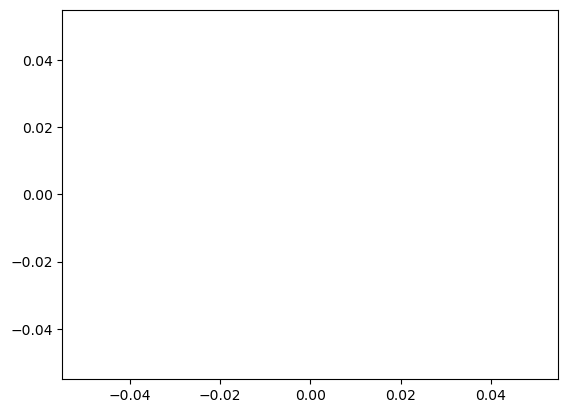

In [126]:
#data = df_flights_overview

#fig = plt.figure()
plt.bar(df_flights_overview['faa'], df_flights_overview['affected'], color = 'g')
plt.show()




# plt.bar(df['faa'], df['cancel_tot'], color = 'y')
# plt.xlabel("Airports", fontsize = 12)
# plt.ylabel("Number of cancelled flights", fontsize = 12)

# plt.show()

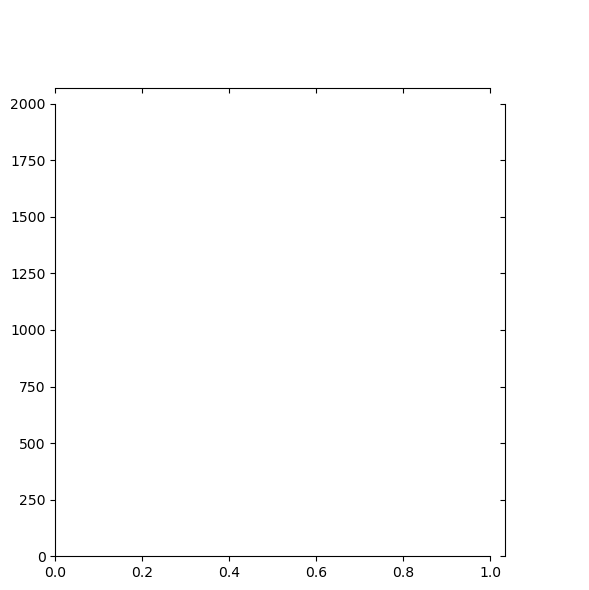

In [114]:
sns.jointplot(data = df_flights_overview, 
                  x = 'flight_date', 
                  #xlim = (-80,60), 
                  y = 'affected', 
                  ylim = (0,2000),
                  #s = 30, # this is setting the size of the dots
                  kind = 'scatter');

In [115]:
schema = 'cgn_analytics_22_3'
flights_daily = f'select * from {schema}.gp3_cancelflight_sum ;'
df = get_dataframe(flights_daily)

In [116]:
df.head()

,flight_date,faa,cancel_tot,diverted_tot,affected,snow,windspeed,rain,tempavg,tempmax
0,2014-01-25,ATL,16,3,19,0.0,15.1,0.0,-1.2,9.4
1,2014-01-26,ATL,15,5,20,0.0,11.9,0.0,5.4,15.0
2,2014-01-27,ATL,30,2,32,0.0,16.6,0.0,10.6,16.1
3,2014-01-28,ATL,1149,17,1166,0.0,19.1,5.8,-1.9,-1.0
4,2014-01-29,ATL,1487,6,1493,50.0,15.5,0.0,-6.4,-2.1


In [119]:
df.describe()

,cancel_tot,diverted_tot,affected,snow,windspeed,rain,tempavg,tempmax
count,34.000000,34.000000,34.000000,28.000000,33.000000,28.000000,33.000000,33.000000
mean,182.235294,2.382353,184.617647,26.785714,14.506061,1.935714,3.475758,9.721212
std,340.947437,3.402447,342.831615,41.904085,7.058193,3.961595,10.221883,11.017167
min,1.000000,0.000000,1.000000,0.000000,3.600000,0.000000,-20.700000,-16.000000
25%,10.500000,0.000000,13.000000,0.000000,7.900000,0.000000,-4.300000,0.600000
50%,37.000000,2.000000,39.500000,0.000000,14.400000,0.000000,3.800000,13.200000
75%,176.250000,3.000000,177.750000,57.500000,19.100000,0.700000,12.800000,18.100000
max,1487.000000,17.000000,1493.000000,130.000000,29.200000,15.000000,19.400000,27.200000


In [117]:
#boxplot with airport and cancellation of the flights
# define style
plt.style.use('seaborn-bright') 



TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

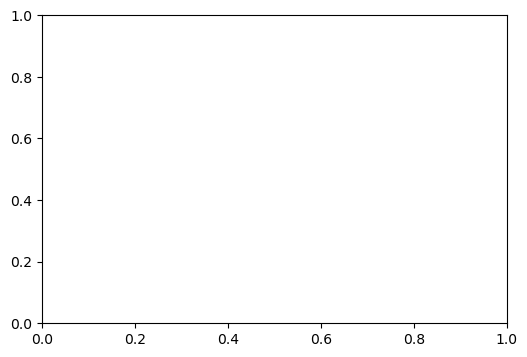

In [118]:
# # Set figure size
plt.figure(figsize=(6, 4))

# Create boxplots for distribution of alcohol and fixed acidity
plt.boxplot(x = [df['faa'], df['cancel_tot']])

# Set locations and labels of ticks on x-axis as well as rotation
plt.xticks(ticks=[1, 2], labels=['airport codes', 'number of cancelled flights'], rotation=45)

# Set title
plt.title("Distribution of cancelled flights", fontsize = 15)

# Show graphic
plt.show()



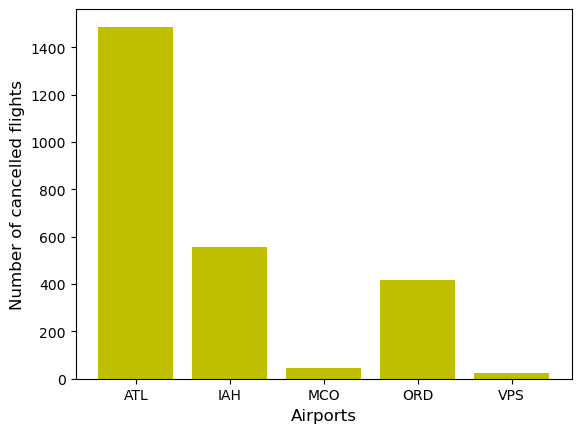

In [92]:
#df['faa'], df['cancel_tot']]
plt.bar(df['faa'], df['cancel_tot'], color = 'y')
plt.xlabel("Airports", fontsize = 12)
plt.ylabel("Number of cancelled flights", fontsize = 12)

plt.show()


In [57]:
#correlation in between amount of snow and cancelled flights

# correlation matrix between these variables
corr_columns=['cancel_tot', 'windspeed', 'rain', 'snow']
corr_mtrx=df[corr_columns].corr()
corr_mtrx

,cancel_tot,windspeed,rain,snow
cancel_tot,1.000000,0.123905,-0.076444,0.176308
windspeed,0.123905,1.000000,-0.015902,0.595185
rain,-0.076444,-0.015902,1.000000,-0.193831
snow,0.176308,0.595185,-0.193831,1.000000


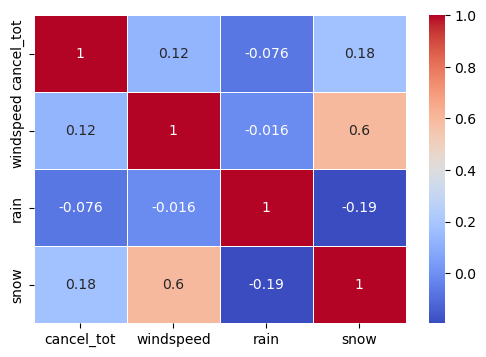

In [94]:
# draw the heatmap
plt.figure(figsize = (6,4))
ax = sns.heatmap(corr_mtrx, linewidths=.5, annot=True, cmap='coolwarm')